In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as mlt
import seaborn as sp
from torch.autograd import Variable
from torch import autograd
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import timedelta
import sys
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from scipy.stats import ks_2samp
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [234]:
%run ../Pre_process/Data_preprocess.ipynb
%run Model/Mogrifier_LSTM.ipynb
%run Model/Bi_LSTM.ipynb
%run Model/LSTM.ipynb
%run Model/SciNet.ipynb
%run train.ipynb
%run ../visualize.ipynb
%run test.ipynb
%run ../validation.ipynb

In [201]:
columns = ['Energy']

In [202]:
#df = pd.read_csv(processed_data_csv)
#df.drop(columns=['Start', 'Year', 'Day of week', 'Week Day', 'Month', 'Day of month'], inplace=True)
#df1 = pd.read_csv(processed_data_csv)
data2 = pd.read_csv("../Data/Processed/acn_data_with_zero.csv")
data1 = pd.read_csv("../Data/Processed/palo_alto_data_with_zero.csv")
data3 = pd.read_csv("../Data/Processed/boulder_data_with_zero.csv")
data3 = data3.loc[(data3['Start'] >= '2019-01-01 00:00:00') & (data3['Start'] <= '2019-12-31 23:00:00')]
data1 = data1.loc[(data1['Start'] >= '2017-01-01 00:00:00') & (data1['Start'] <= '2018-01-01 23:00:00')]
data2 = data2.loc[(data2['Start'] >= '2018-01-02 00:00:00') & (data2['Start'] <= '2018-12-31 23:00:00')]
df = pd.concat([data1, data2, data3], axis=0).reset_index(drop=True)
#df['Hour'] = pd.to_datetime(df['Start']).dt.hour
#df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
#df.drop(columns=['Start'], inplace=True)
df.drop(columns=['Start', 'Year', 'Day of week', 'Week Day', 'Month', 'Day of month'], inplace=True)


In [203]:
input_size = df.shape[1]
hidden_size = 7

In [204]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
#df = pd.DataFrame(df, columns=['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour', 'Sum'])
df = pd.DataFrame(df, columns=columns)

In [205]:
train_ratio = 0.80

In [206]:
data_train, data_test, ground_truth_train, ground_truth_test = get_train_test_dataset_forecasting(df, train_ratio)

In [207]:
step_per_epoch = len(data_train) // batch_size

# Converting to tensor
data_train = torch.from_numpy(data_train).float().to(device)
ground_truth_train = torch.from_numpy(ground_truth_train).float().to(device)


# Mogrifier LSTM

Trainning------------------------------------------------------------------------------------------------------------------------------

In [208]:
model = Mogrifier_LSTM(input_size, hidden_size, future_step, batch_size).to(device)
#model = Seq2SeqAttention(input_size, hidden_size, input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.005)
loss_function_mogrifier = nn.MSELoss()

In [209]:
real_dataset_mogrifier, gen_dataset_mogrifier, errors_generator_mogrifier = train_mogrifier_lstm(model, optimizer, loss_function_mogrifier, data_train, ground_truth_train, step_per_epoch)

Epoch: 0 Loss G.: 10.679712295532227
Epoch: 1 Loss G.: 9.541128158569336
Epoch: 2 Loss G.: 3.6644346714019775
Epoch: 3 Loss G.: 4.368545055389404
Epoch: 4 Loss G.: 3.5575122833251953
Epoch: 5 Loss G.: 3.501070261001587
Epoch: 6 Loss G.: 3.414581537246704
Epoch: 7 Loss G.: 3.3620846271514893
Epoch: 8 Loss G.: 3.3235628604888916
Epoch: 9 Loss G.: 3.297712802886963
Epoch: 10 Loss G.: 3.2742855548858643
Epoch: 11 Loss G.: 3.255145788192749
Epoch: 12 Loss G.: 3.2438149452209473
Epoch: 13 Loss G.: 3.2303011417388916
Epoch: 14 Loss G.: 3.2158453464508057
Epoch: 15 Loss G.: 3.201589822769165
Epoch: 16 Loss G.: 3.190896511077881
Epoch: 17 Loss G.: 3.1837687492370605
Epoch: 18 Loss G.: 3.176589012145996
Epoch: 19 Loss G.: 3.1668338775634766
Epoch: 20 Loss G.: 3.152099609375
Epoch: 21 Loss G.: 3.133955478668213
Epoch: 22 Loss G.: 3.117521047592163
Epoch: 23 Loss G.: 3.104135513305664
Epoch: 24 Loss G.: 3.091917037963867
Epoch: 25 Loss G.: 3.0802440643310547
Epoch: 26 Loss G.: 3.06754732131958
Epo

In [214]:
gen_dataset_mogrifier.shape

torch.Size([18432, 24, 1])

In [215]:
real_dataset_mogrifier.shape

torch.Size([18432, 24, 1])

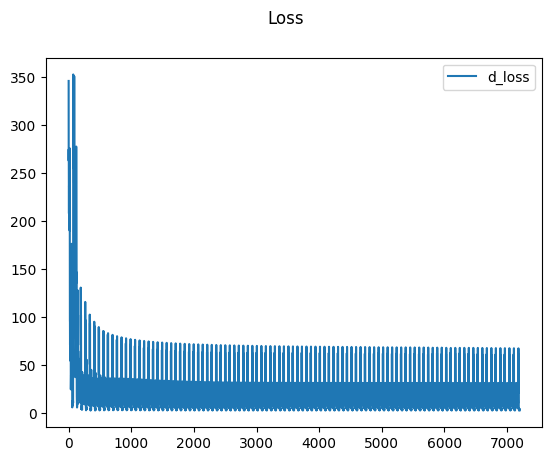

In [210]:
mlt.suptitle('Loss')
mlt.plot(errors_generator_mogrifier, label='d_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

In [211]:
gen_dataset_mogrifier.view(batch_size, -1).shape

torch.Size([256, 1728])

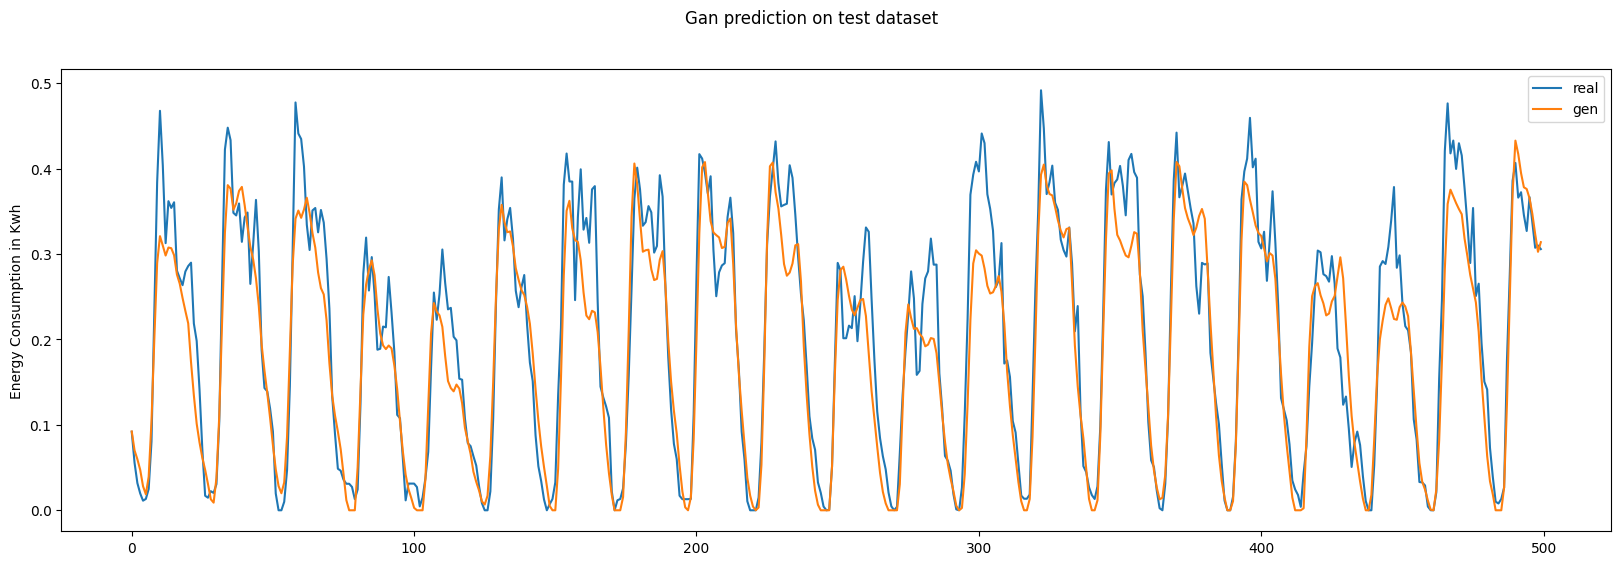

In [217]:
plot_full_dataset(real_dataset_mogrifier[:, -1, :].detach().cpu().numpy(), gen_dataset_mogrifier[:, -1, :].detach().cpu().numpy(), 000, 500, 'Results/test1.png', 0)

In [218]:
real_dataset_mogrifier.shape

torch.Size([18432, 24, 1])

Testing-------------------------------------------------------------------------------------------------------------------------------

In [ ]:
impute_folders = ['Seq2Seq', 'Mean_imputation', 'Knn']
datasets = ['acn', 'boulder', 'dundee', 'palo_alto', 'perth', 'sap']

In [ ]:
impute_folders = ['Processed']
datasets = ['acn_data_with_zero', 'boulder_data_with_zero', 'dundee_data_with_zero', 'palo_alto_data_with_zero', 'perth_data_with_zero', 'sap_data_with_zero']

In [224]:
df = pd.read_csv("../Data/Imputed/Seq2Seq/acn.csv")
df.drop(columns=['Day of week', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour', 'Sum'], inplace=True)
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=columns)

In [237]:
input_size = 1

In [225]:
train_ratio = 0

In [226]:

_, data_test, _, ground_truth_test = get_train_test_dataset_forecasting(df, train_ratio)

In [227]:
data_test = data_test[: -(data_test.shape[0] % batch_size)]
ground_truth_test = ground_truth_test[: -(ground_truth_test.shape[0] % batch_size)]

In [228]:
step_per_epoch = len(data_test) // batch_size

In [229]:
df.shape

(12800, 1)

In [230]:
# tr = df['Energy']
# mlt.figure(figsize=(20, 6))
# mlt.suptitle('Gan prediction on test dataset')
# mlt.ylabel('Energy Consumption in Kwh')
# mlt.plot(tr, label='real')
# mlt.legend()
# mlt.show()

In [231]:
data_test = torch.from_numpy(data_test).float().to(device)
ground_truth_test = torch.from_numpy(ground_truth_test).float().to(device)

In [238]:
real_dataset_test_mogrifier, predicted_dataset_mogrifier, loss = test_model(model, data_test, ground_truth_test, loss_function_mogrifier, step_per_epoch)

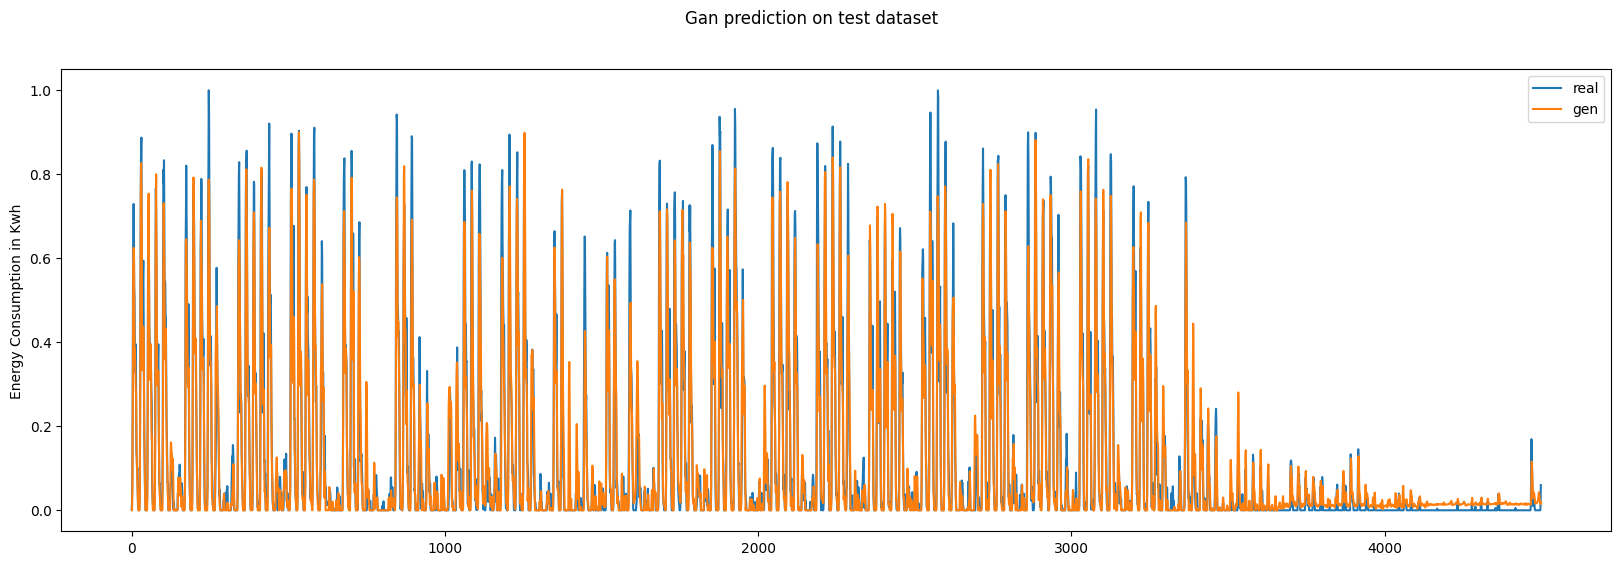

In [240]:
plot_full_dataset(real_dataset_test_mogrifier.detach().cpu().numpy(), predicted_dataset_mogrifier.detach().cpu().numpy(), 000, 4500, 'Results/test3.png', 0)

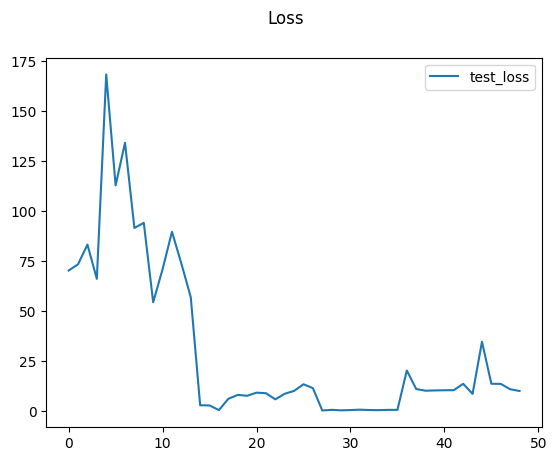

In [241]:
mlt.suptitle('Loss')
#mlt.plot(errors_generator, label='train_loss')
mlt.plot(loss[:], label='test_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

Evaluation----------------------------------------------------------------------------------------------------------------

In [1363]:
validation_matrix_forecasting(real_dataset_test_mogrifier.view(-1).detach().cpu().numpy(), predicted_dataset_mogrifier.view(-1).detach().cpu().numpy(), 0)

RMSE:0.11384037882089615
MAE: 0.07514561
MSE: 0.012959631
R-squared: -0.005949334948749163


# Bi LSTM

In [1468]:
hidden_size = 16
model = Bi_LSTM(input_size, hidden_size, future_step).to(device)
#model = Seq2SeqAttention(input_size, hidden_size, input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.005)
loss_function_bilstm = nn.MSELoss()

In [1469]:
real_dataset_bilstm, gen_dataset_bilstm, errors_generator_bilstm = train_bi_lstm(model, optimizer, loss_function_bilstm, data_train, ground_truth_train, step_per_epoch)

Epoch: 0 Loss G.: 9.477092742919922
Epoch: 1 Loss G.: 14.136211395263672
Epoch: 2 Loss G.: 18.56473159790039
Epoch: 3 Loss G.: 16.246423721313477
Epoch: 4 Loss G.: 12.626325607299805
Epoch: 5 Loss G.: 9.659293174743652
Epoch: 6 Loss G.: 7.089956760406494
Epoch: 7 Loss G.: 4.941044330596924
Epoch: 8 Loss G.: 3.7090351581573486
Epoch: 9 Loss G.: 3.3572144508361816
Epoch: 10 Loss G.: 3.3642358779907227
Epoch: 11 Loss G.: 3.3325767517089844
Epoch: 12 Loss G.: 3.1827213764190674
Epoch: 13 Loss G.: 2.982279062271118
Epoch: 14 Loss G.: 2.6809115409851074
Epoch: 15 Loss G.: 2.49404239654541
Epoch: 16 Loss G.: 2.408419609069824
Epoch: 17 Loss G.: 2.23239803314209
Epoch: 18 Loss G.: 2.1309008598327637
Epoch: 19 Loss G.: 2.0338428020477295
Epoch: 20 Loss G.: 1.973116397857666
Epoch: 21 Loss G.: 1.9360456466674805
Epoch: 22 Loss G.: 2.0128209590911865
Epoch: 23 Loss G.: 1.8796292543411255
Epoch: 24 Loss G.: 1.9662628173828125
Epoch: 25 Loss G.: 1.6560591459274292
Epoch: 26 Loss G.: 1.6125342845916

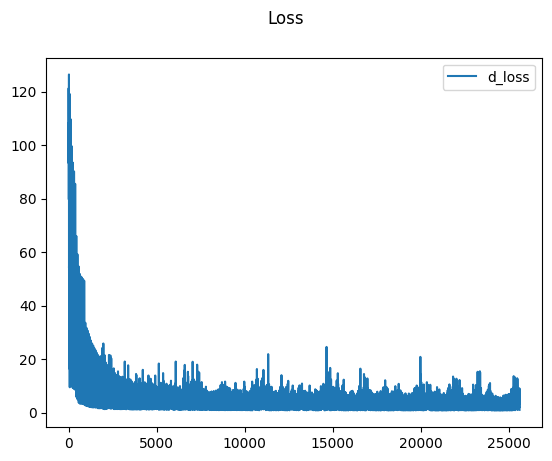

In [1473]:
mlt.suptitle('Loss')
mlt.plot(errors_generator_bilstm, label='d_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

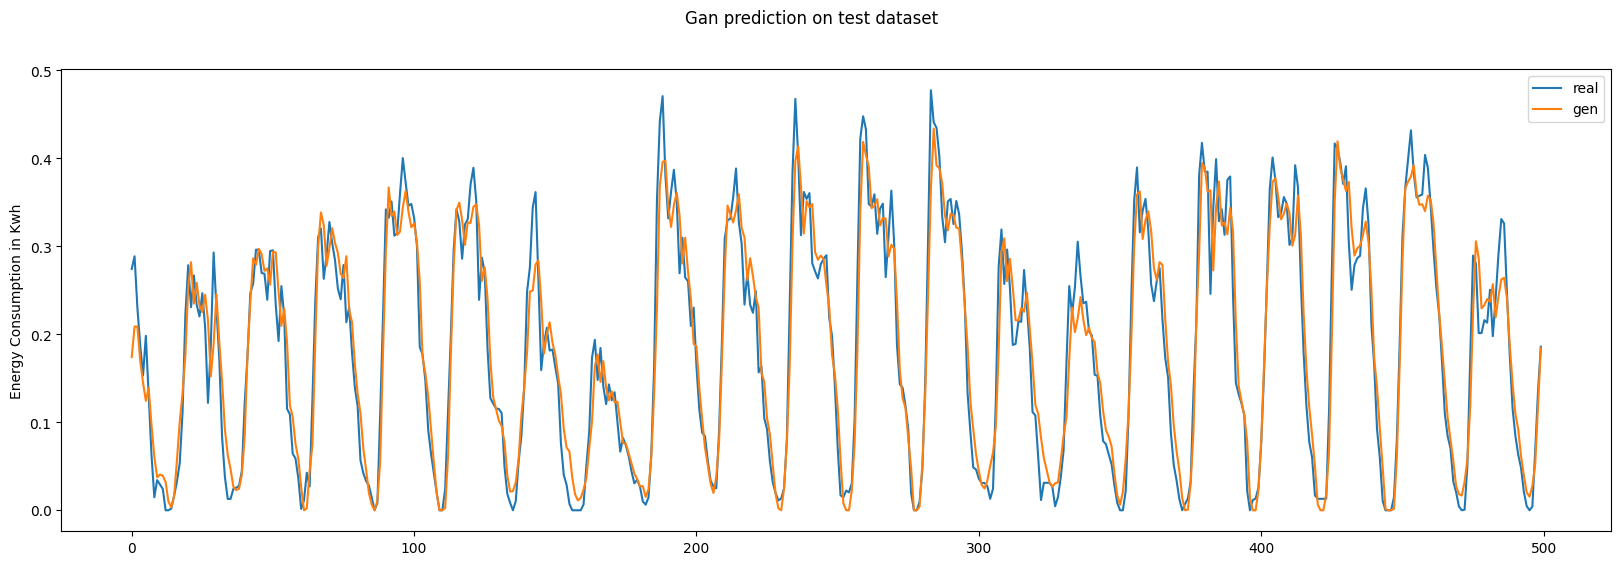

In [1474]:
plot_full_dataset(real_dataset_bilstm[:].detach().cpu().numpy(), gen_dataset_bilstm[:].detach().cpu().numpy(), 00, 500, 'Results/test1.png', 0)

In [1696]:
df = pd.read_csv("../Data/Imputed/Mean_imputation/perth.csv")
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour', 'Sum'])

In [1697]:
train_ratio = 0

In [1698]:
_, data_test, _, ground_truth_test = get_train_test_dataset_forecasting(df, train_ratio)

In [1699]:
data_test = data_test[: -(data_test.shape[0] % batch_size)]
ground_truth_test = ground_truth_test[: -(ground_truth_test.shape[0] % batch_size)]

In [1700]:
step_per_epoch = len(data_test) // batch_size

In [1701]:
data_test = torch.from_numpy(data_test).float().to(device)
ground_truth_test = torch.from_numpy(ground_truth_test).float().to(device)

In [1702]:
real_data_bilstm, predicted_data_bilstm, loss_bilstm = test_model(model, data_test, ground_truth_test, loss_function_bilstm, step_per_epoch)

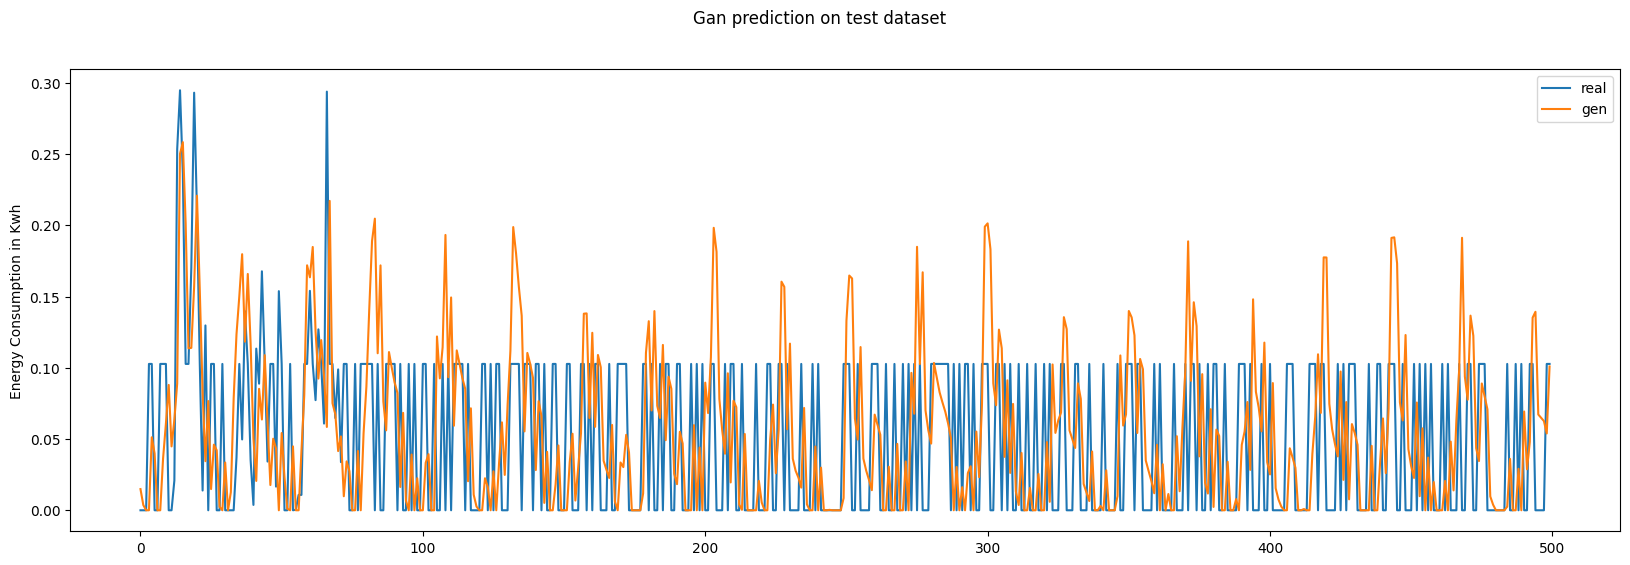

In [1703]:
plot_full_dataset(real_data_bilstm.detach().cpu().numpy(), predicted_data_bilstm.detach().cpu().numpy(), 000, 500, 'Results/test3.png', 0)

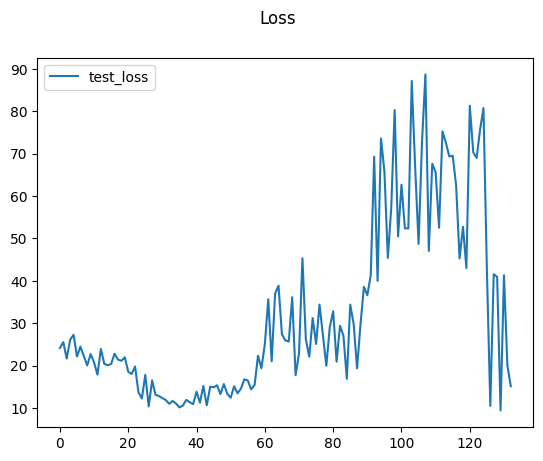

In [1704]:
mlt.suptitle('Loss')
#mlt.plot(errors_generator, label='train_loss')
mlt.plot(loss_bilstm[:], label='test_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

In [1705]:
validation_matrix_forecasting(real_data_bilstm.view(-1).detach().cpu().numpy(), predicted_data_bilstm.view(-1).detach().cpu().numpy(), 0)

RMSE:0.12529373168945312
MAE: 0.0832894
MSE: 0.015698519
R-squared: -0.21851946653544108


# Vanilla LSTM

In [1766]:
hidden_size = 16
model = vanilla_LSTM(input_size, hidden_size, future_step).to(device)
#model = Seq2SeqAttention(input_size, hidden_size, input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.005)
loss_function_seq2seq = nn.MSELoss()

In [1767]:
real_dataset_vanilla_lstm, gen_dataset_vanilla_lstm, errors_generator_vanilla_lstm = train_vanilla_lstm(model, optimizer, loss_function_seq2seq, data_train, ground_truth_train, step_per_epoch)

Epoch: 0 Loss G.: 8.976898193359375
Epoch: 1 Loss G.: 11.4050874710083
Epoch: 2 Loss G.: 16.33896827697754
Epoch: 3 Loss G.: 19.581619262695312
Epoch: 4 Loss G.: 14.89157485961914
Epoch: 5 Loss G.: 12.813374519348145
Epoch: 6 Loss G.: 11.18997859954834
Epoch: 7 Loss G.: 8.219956398010254
Epoch: 8 Loss G.: 5.920682430267334
Epoch: 9 Loss G.: 4.732049465179443
Epoch: 10 Loss G.: 3.919621706008911
Epoch: 11 Loss G.: 3.464674711227417
Epoch: 12 Loss G.: 3.2161505222320557
Epoch: 13 Loss G.: 3.086013078689575
Epoch: 14 Loss G.: 2.9957644939422607
Epoch: 15 Loss G.: 2.9096896648406982
Epoch: 16 Loss G.: 2.8267669677734375
Epoch: 17 Loss G.: 2.743757963180542
Epoch: 18 Loss G.: 2.6692986488342285
Epoch: 19 Loss G.: 2.6069726943969727
Epoch: 20 Loss G.: 2.552382707595825
Epoch: 21 Loss G.: 2.5051627159118652
Epoch: 22 Loss G.: 2.4520699977874756
Epoch: 23 Loss G.: 2.3894388675689697
Epoch: 24 Loss G.: 2.316826581954956
Epoch: 25 Loss G.: 2.240720748901367
Epoch: 26 Loss G.: 2.1702725887298584


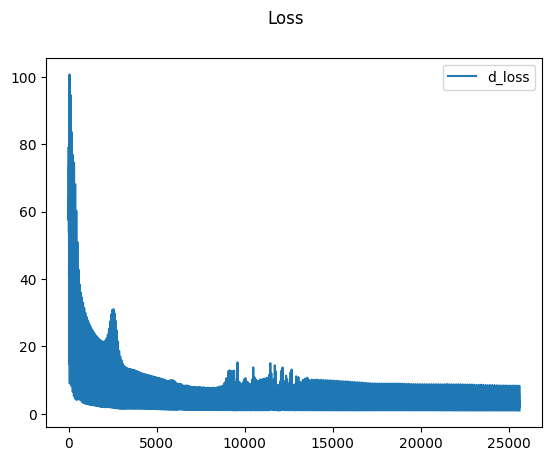

In [1768]:
mlt.suptitle('Loss')
mlt.plot(errors_generator_vanilla_lstm, label='d_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

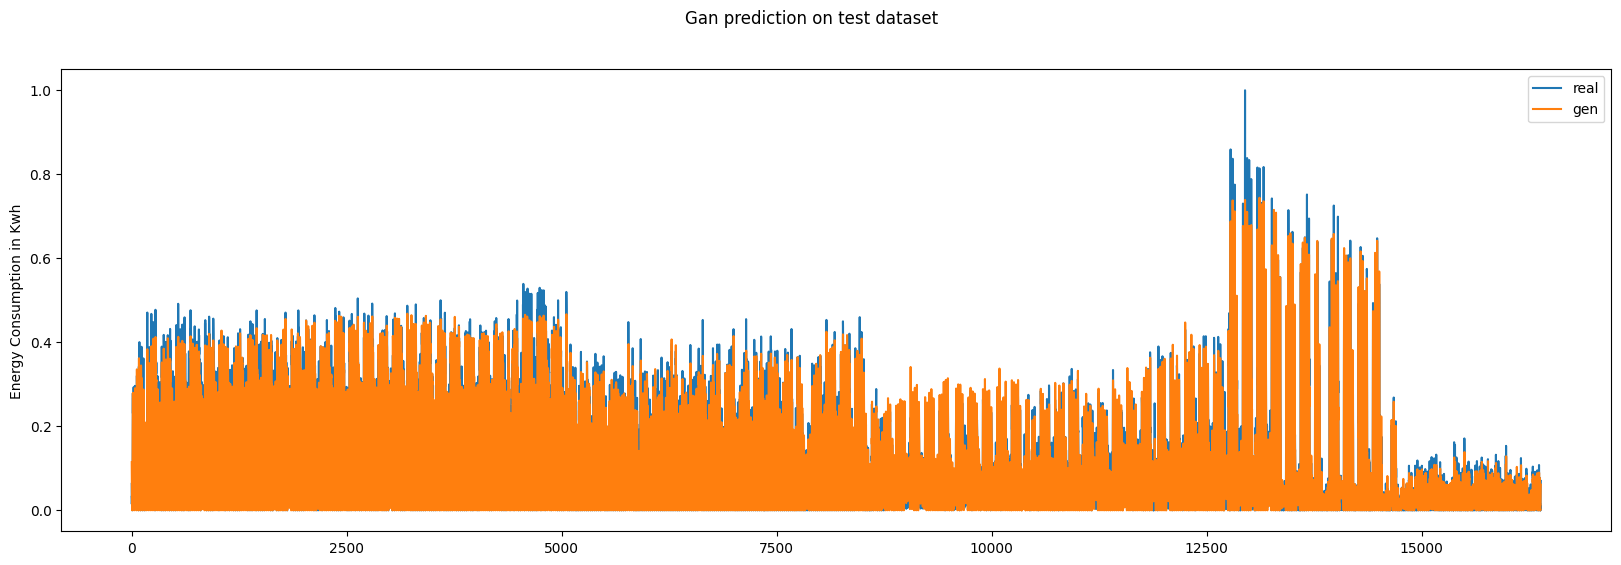

In [1769]:
plot_full_dataset(real_dataset_vanilla_lstm[:].detach().cpu().numpy(), gen_dataset_vanilla_lstm[:].detach().cpu().numpy(), 00, 50000, 'Results/test1.png', 0)

In [1971]:
df = pd.read_csv("../Data/Imputed/Mean_imputation/perth.csv")
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour', 'Sum'])

In [1972]:
train_ratio = 0

In [1973]:
_, data_test, _, ground_truth_test = get_train_test_dataset_forecasting(df, train_ratio)

In [1974]:
data_test = data_test[: -(data_test.shape[0] % batch_size)]
ground_truth_test = ground_truth_test[: -(ground_truth_test.shape[0] % batch_size)]

In [1975]:
step_per_epoch = len(data_test) // batch_size

In [1976]:
data_test = torch.from_numpy(data_test).float().to(device)
ground_truth_test = torch.from_numpy(ground_truth_test).float().to(device)

In [1977]:
real_data_lstm, predicted_data_lstm, loss_lstm = test_model(model, data_test, ground_truth_test, loss_function_seq2seq, step_per_epoch)

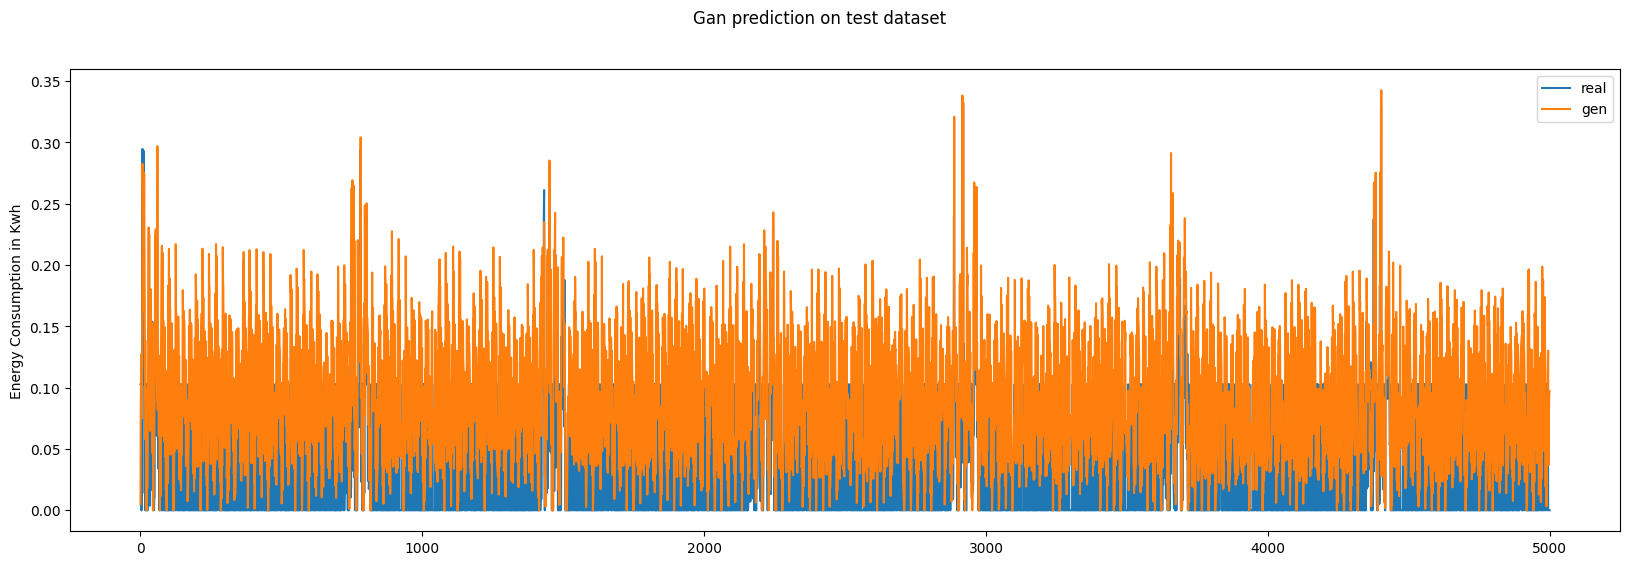

In [1978]:
plot_full_dataset(real_data_lstm.detach().cpu().numpy(), predicted_data_lstm.detach().cpu().numpy(), 000, 5000, 'Results/test3.png', 0)

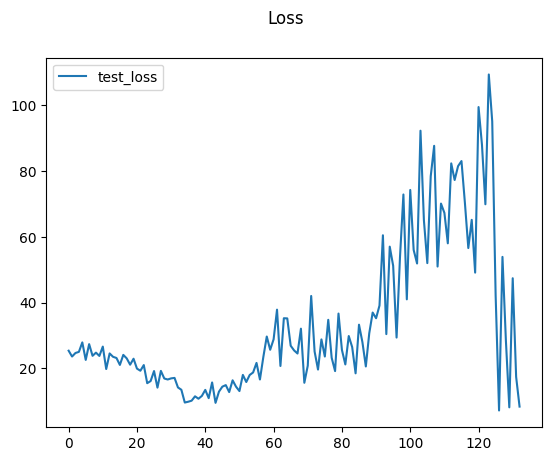

In [1979]:
mlt.suptitle('Loss')
#mlt.plot(errors_generator, label='train_loss')
mlt.plot(loss_lstm[:], label='test_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

In [1980]:
validation_matrix_forecasting(real_data_lstm.view(-1).detach().cpu().numpy(), predicted_data_lstm.view(-1).detach().cpu().numpy(), 0)

RMSE:0.12791748344898224
MAE: 0.0863177
MSE: 0.016362881
R-squared: -0.2701157592418735


In [1992]:
predicted_data_lstm.shape

torch.Size([34048, 8])

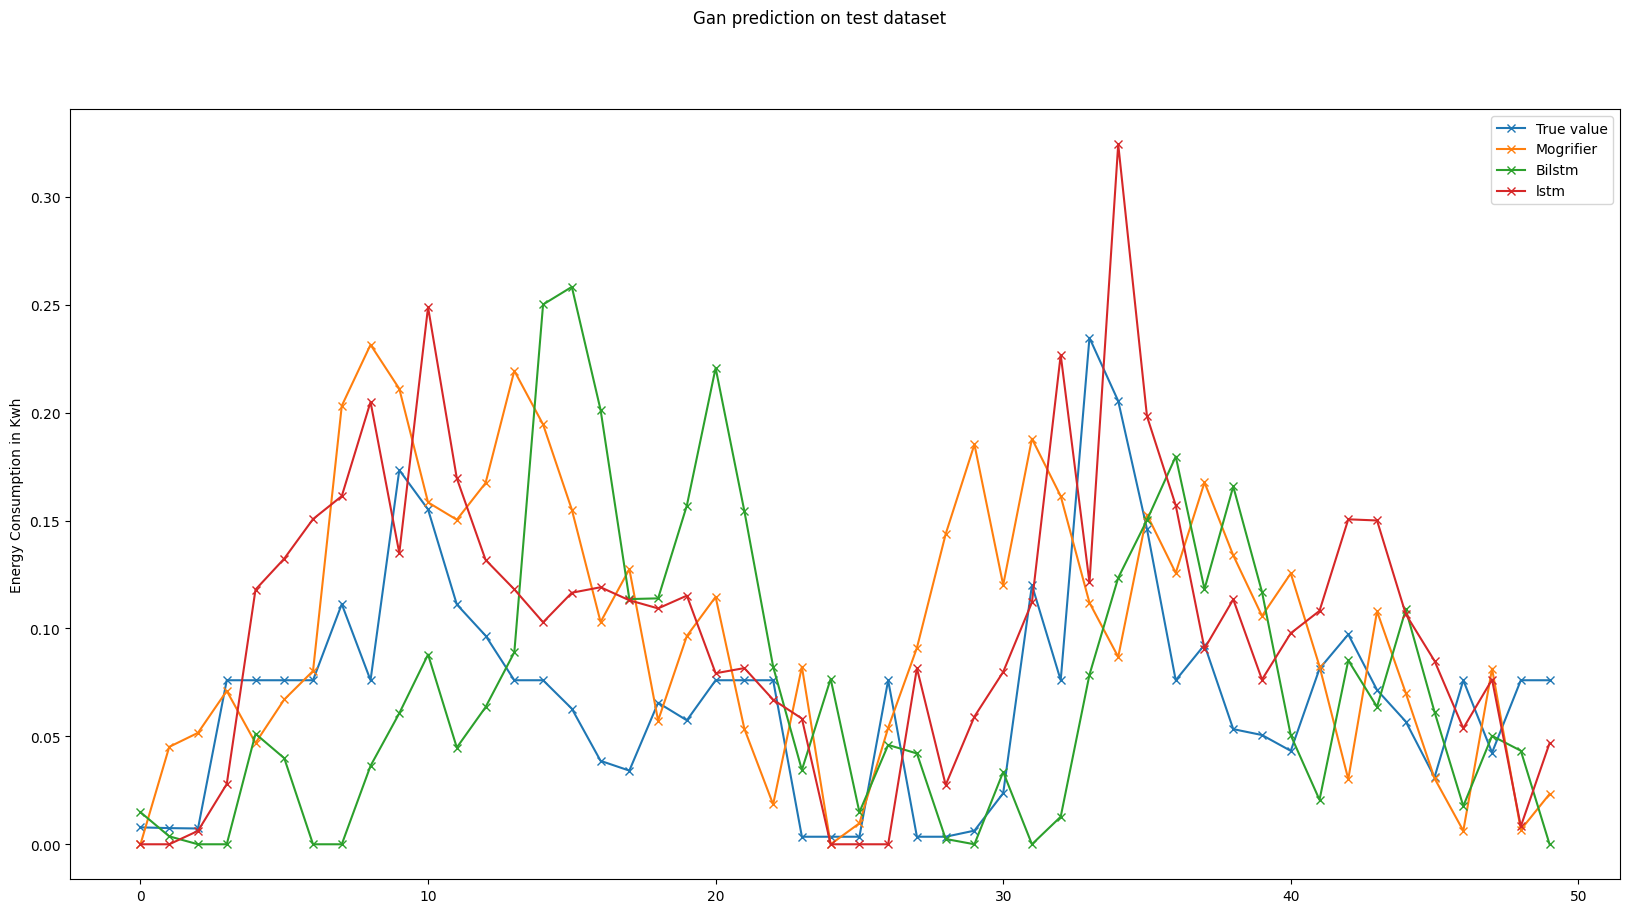

In [1940]:
compare_predicted_dataset(real_data_lstm.detach().cpu().numpy(), predicted_dataset_mogrifier.detach().cpu().numpy(), predicted_data_bilstm.detach().cpu().numpy(), predicted_data_lstm.detach().cpu().numpy(), 000, 50, 'Results/compare.png', 0)

# Scinet

In [179]:
stacks = 1
levels = 3

In [180]:
model = SCINet(output_len = future_step, input_len= lag_size, input_dim = input_size, hid_size = hidden_size, num_stacks = stacks,
                num_levels = levels, concat_len = 0, groups = 1, kernel = 4, dropout = 0.3,
                 single_step_output_One = 0, positionalE =  False, modified = True).to(device)
#model = Seq2SeqAttention(input_size, hidden_size, input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.005)
loss_function_scinet = nn.L1Loss()

In [181]:
real_dataset_scinet, gen_dataset_scinet, errors_generator_scinet = train_scinet(model, loss_function_scinet, optimizer, data_train, ground_truth_train, step_per_epoch)

Epoch: 0 Loss G.: 0.11116275191307068
Epoch: 1 Loss G.: 0.062263471281362906
Epoch: 2 Loss G.: 0.052878364299734436
Epoch: 3 Loss G.: 0.05031724085306956
Epoch: 4 Loss G.: 0.053431430391760334
Epoch: 5 Loss G.: 0.03956639451078243
Epoch: 6 Loss G.: 0.040490145329385996
Epoch: 7 Loss G.: 0.04048228067242437
Epoch: 8 Loss G.: 0.041716468365242086
Epoch: 9 Loss G.: 0.03442317578527662
Epoch: 10 Loss G.: 0.03406380468772517
Epoch: 11 Loss G.: 0.03595673225613104
Epoch: 12 Loss G.: 0.035273362533189356
Epoch: 13 Loss G.: 0.03413186510766132
Epoch: 14 Loss G.: 0.03955485325099693
Epoch: 15 Loss G.: 0.034657368850376874
Epoch: 16 Loss G.: 0.03463356561648349
Epoch: 17 Loss G.: 0.03948459246506294
Epoch: 18 Loss G.: 0.03433119849715796
Epoch: 19 Loss G.: 0.035015273451184235
Epoch: 20 Loss G.: 0.04023535490139491
Epoch: 21 Loss G.: 0.03413562091170914
Epoch: 22 Loss G.: 0.034078654574437275
Epoch: 23 Loss G.: 0.03620062743882752
Epoch: 24 Loss G.: 0.036953879119310945
Epoch: 25 Loss G.: 0.0351

In [182]:
gen_dataset_scinet.shape

torch.Size([18432, 24, 1])

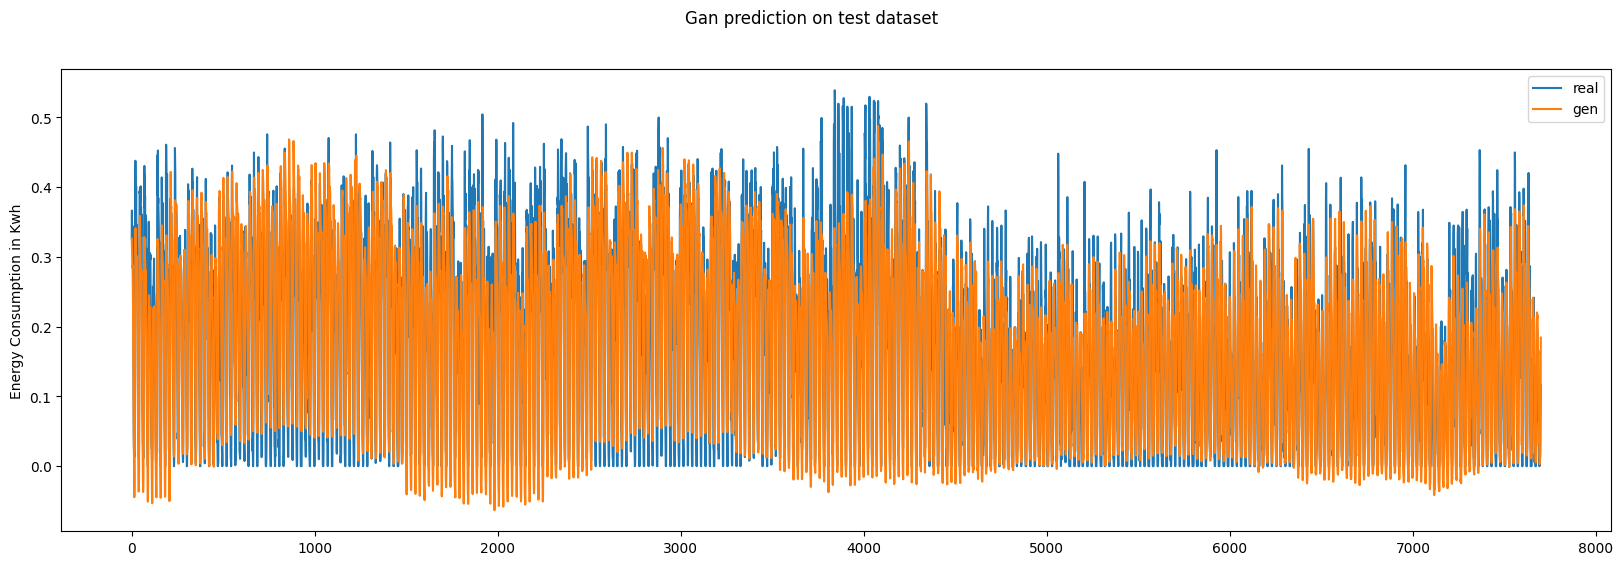

In [183]:
plot_full_dataset(real_dataset_scinet.detach().cpu().numpy(), gen_dataset_scinet.detach().cpu().numpy(), 300, 8000, 'Results/test1.png', 1)

# Test

In [242]:
impute_folders = ['Seq2Seq', 'Mean_imputation', 'Knn']
datasets = ['acn', 'boulder', 'dundee', 'palo_alto', 'perth', 'sap']

In [187]:
impute_folders = ['Processed']
datasets = ['acn_data_with_zero', 'boulder_data_with_zero', 'dundee_data_with_zero', 'palo_alto_data_with_zero', 'perth_data_with_zero', 'sap_data_with_zero']

In [ ]:
model.eval()

In [244]:
for i in impute_folders:
    print(i + "---->")
    for j in datasets:
        print(j + ":")
        df = pd.read_csv("../Data/Imputed/" + i + "/" + j + ".csv")
        #df = df[: 8760]
        # df.drop(columns=['Start', 'Year', 'Day of week', 'Week Day', 'Month', 'Day of month'], inplace=True)
        df.drop(columns=['Day of week', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour', 'Sum'], inplace=True)
        scaler = MinMaxScaler(feature_range=(0,1))
        df = scaler.fit_transform(df)
        df = pd.DataFrame(df, columns=columns)

        train_ratio = 0

        _, data_test, _, ground_truth_test = get_train_test_dataset_forecasting(df, train_ratio)

        # data_test = data_test[: -(data_test.shape[0] % batch_size)]
        # ground_truth_test = ground_truth_test[: -(ground_truth_test.shape[0] % batch_size)]

        data_test = torch.from_numpy(data_test).float().to(device)
        ground_truth_test = torch.from_numpy(ground_truth_test).float().to(device)

        with torch.no_grad():
            if stacks == 1:
                outputs = model(data_test)
            elif stacks == 2:
                outputs, _ = model(data_test)

        ground_truth_test = pd.DataFrame(ground_truth_test[:, -1, :].detach().cpu().numpy(), columns=columns)
        ground_truth_test = scaler.inverse_transform(ground_truth_test)
        ground_truth_test = torch.tensor(ground_truth_test)

        outputs = pd.DataFrame(outputs[:, -1, :].detach().cpu().numpy(), columns=columns)
        outputs = scaler.inverse_transform(outputs)
        outputs = torch.tensor(outputs)

        validation_matrix_forecasting(ground_truth_test.detach().cpu().numpy(), outputs.detach().cpu().numpy(), 1)


Seq2Seq---->
acn:


RuntimeError: The size of tensor a (256) must match the size of tensor b (12560) at non-singleton dimension 0

In [108]:
df = pd.read_csv("../Data/Processed/acn_data_with_zero.csv")
df = df[: 8760]
df.drop(columns=['Start', 'Year', 'Day of week', 'Week Day', 'Month', 'Day of month'], inplace=True)
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=columns)

In [99]:
train_ratio = 0

In [100]:

_, data_test, _, ground_truth_test = get_train_test_dataset_forecasting(df, train_ratio)

In [101]:
data_test = data_test[: -(data_test.shape[0] % batch_size)]
ground_truth_test = ground_truth_test[: -(ground_truth_test.shape[0] % batch_size)]

In [146]:
data_test = torch.from_numpy(data_test).float().to(device)
ground_truth_test = torch.from_numpy(ground_truth_test).float().to(device)

In [147]:
model.eval()
with torch.no_grad():
    if stacks == 1:
        outputs = model(data_test)
    elif stacks == 2:
        outputs, _ = model(data_test)

In [148]:
outputs.shape

torch.Size([4624, 12, 1])

In [149]:
ground_truth_test = pd.DataFrame(ground_truth_test[:, -1, :].detach().cpu().numpy(), columns=['Energy'])
ground_truth_test = scaler.inverse_transform(ground_truth_test)
ground_truth_test = torch.tensor(ground_truth_test)

outputs = pd.DataFrame(outputs[:, -1, :].detach().cpu().numpy(), columns=['Energy'])
outputs = scaler.inverse_transform(outputs)
outputs = torch.tensor(outputs)

In [150]:
ground_truth_test.shape

torch.Size([4624, 1])

In [151]:
validation_matrix_forecasting(ground_truth_test.detach().cpu().numpy(), outputs.detach().cpu().numpy(), 1)

RMSE:6.049882888793945
MAE: 4.2849507
MSE: 36.60108
R-squared: 0.5287146594589852


In [131]:
ground_truth_test.shape

torch.Size([4622, 1])

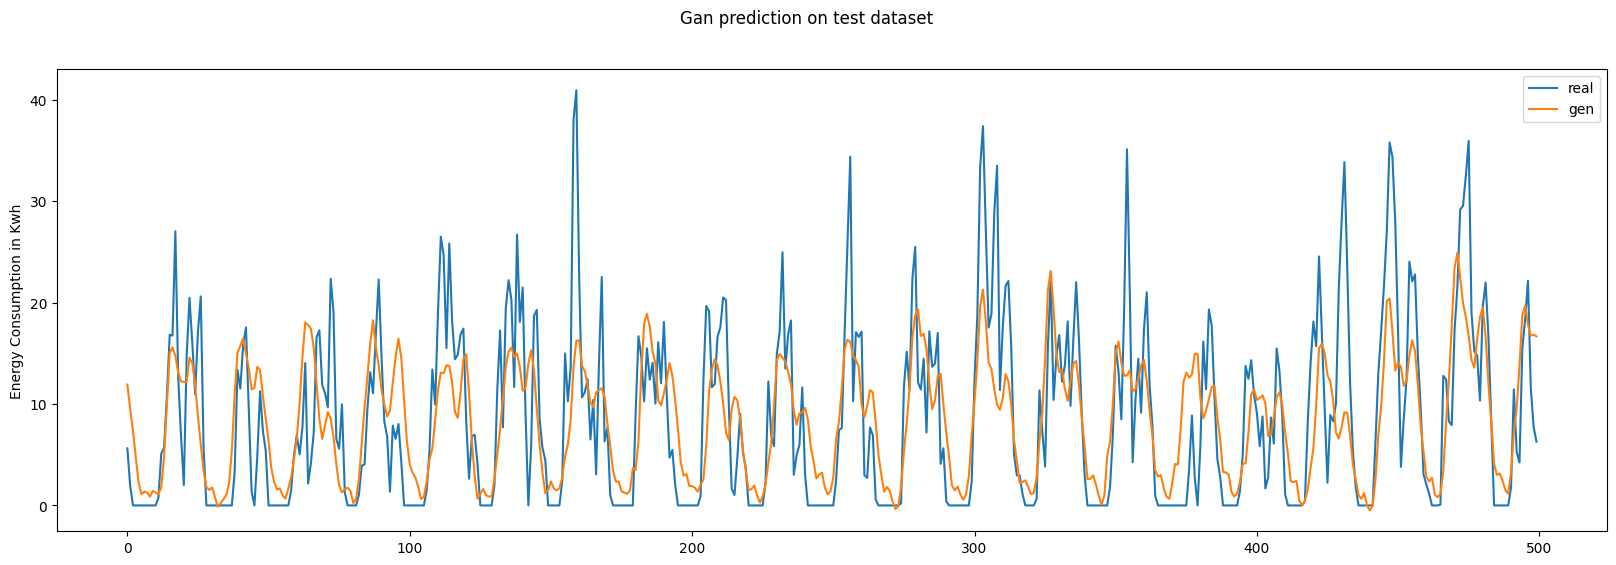

In [132]:
plot_full_dataset(ground_truth_test.detach().cpu().numpy(), outputs.detach().cpu().numpy(), 1000, 1500, 'Results/test1.png', 0)

# Visualize

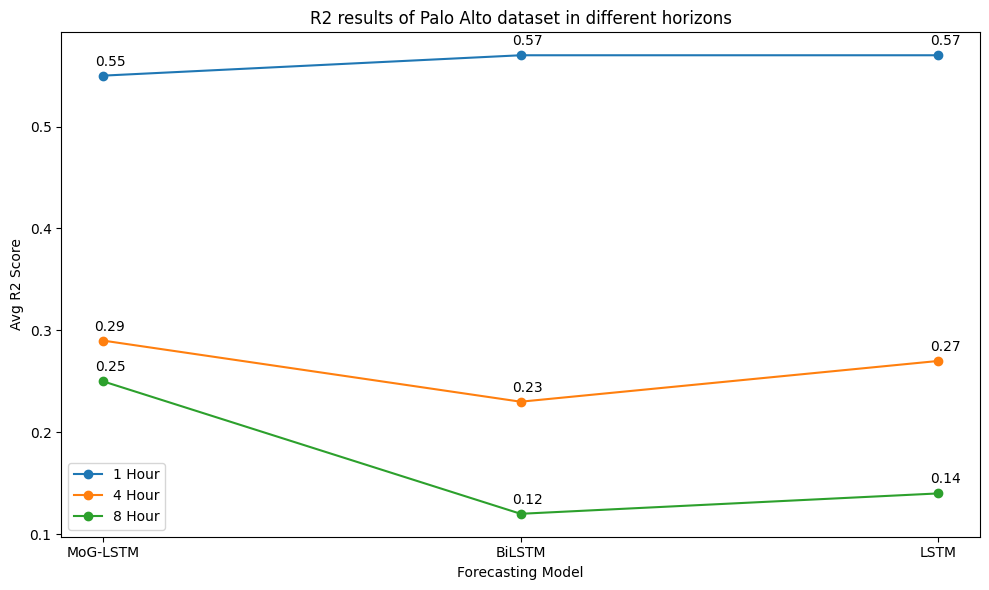

In [1991]:
results = {
    '1 Hour': {'MoG-LSTM': 0.55, 'BiLSTM': 0.57, 'LSTM': 0.57},
    '4 Hour': {'MoG-LSTM': 0.29, 'BiLSTM': 0.23, 'LSTM': 0.27},
    '8 Hour': {'MoG-LSTM': 0.25, 'BiLSTM': 0.12, 'LSTM': 0.14}
}
plot_r2_score(results, "Results/compare_hourly.png")

In [247]:
random_row_indices = np.random.choice(100, size=40, replace=False)

In [248]:
random_row_indices

array([23, 63, 73, 86, 34, 82, 90, 43, 55, 40, 95, 31, 72, 94, 74, 11, 98,
       99, 27, 54, 26, 30, 68,  1, 70, 19, 24, 85, 10,  2, 38, 45, 50, 75,
        0, 97, 41, 83, 60, 57])